In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
np.set_printoptions(linewidth=120, precision=4)

from keras.layers import Input, Conv2D, Activation, Reshape, Lambda
from keras.layers import MaxPool2D, AvgPool2D, MaxPool3D, AvgPool3D
from keras.layers import BatchNormalization, Dropout
from keras.models import Model
from keras import backend as K

### SparseConv2D and PartialConv2D

see [sparseconvolution.ipynb](sparseconvolution.ipynb)

### GroupConv2D

(None, 8, 8, 2)
(None, 4, 4, 12)
input_1                        [(None, 8, 8, 2)]        0        []
group_conv2d                   (None, 8, 8, 8, 12)      216      [(3, 3, 2, 12)]
batch_normalization            (None, 8, 8, 8, 12)      48       [(12,), (12,), (12,), (12,)]
group_conv2d_1                 (None, 8, 8, 8, 12)      10368    [(3, 3, 96, 12)]
average_pooling3d              (None, 4, 4, 8, 12)      0        []
group_conv2d_2                 (None, 4, 4, 8, 12)      10368    [(3, 3, 96, 12)]
max_pooling3d                  (None, 4, 4, 1, 12)      0        []
lambda                         (None, 4, 4, 12)         0        []


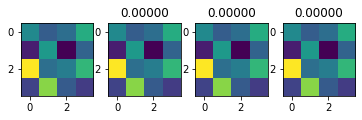

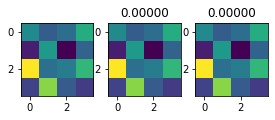

In [2]:
from layers import GroupConv2D

input_shape = (8,8,2)

x = x_in = Input(input_shape)
x = GroupConv2D(12, 3, group='D4', padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = GroupConv2D(12, 3, group='D4', padding='same', activation='relu')(x)
x = AvgPool3D(pool_size=(2,2,1), strides=(2,2,1), padding='same')(x)
x = GroupConv2D(12, 3, group='D4', padding='same', activation='relu')(x)
x = MaxPool3D(pool_size=(1,1,x.shape[-2]))(x)
x = Lambda(lambda x: K.squeeze(x, axis=-2))(x)
model = Model(x_in, x)

print(model.input_shape)
print(model.output_shape)

for l in model.layers:
    print('%-30s %-24s %-8i'%(l.name, str(l.output_shape), l.count_params()), [tuple(w.shape) for w in l.weights])

d = np.random.randn(*input_shape)

# check rotation equivariance
d_rot = np.stack([np.rot90(d, k=k) for k in range(4)])
y_pred = model(d_rot)
y_pred_inv = [np.rot90(y_pred[k], k=-k) for k in range(4)]
for k in range(4):
    plt.subplot(141+k)
    y = y_pred_inv[k][:,:,1]
    plt.imshow(y, vmin=np.min(y), vmax=np.max(y))
    if k > 0:
        plt.title('%.5f' % np.mean(np.abs(y_pred_inv[0]-y_pred_inv[k])))
plt.show()

# check reflection equivariance
d_flip = np.stack([d, np.flip(d,0), np.flip(d,1)])
y_pred = model(d_flip)
y_pred_inv = [y_pred[0], np.flip(y_pred[1],0), np.flip(y_pred[2],1)]
for k in range(3):
    plt.subplot(141+k)
    y = y_pred_inv[k][:,:,1]
    plt.imshow(y, vmin=np.min(y), vmax=np.max(y))
    if k > 0:
        plt.title('%.5f' % np.mean(np.abs(y_pred_inv[0]-y_pred_inv[k])))
plt.show()

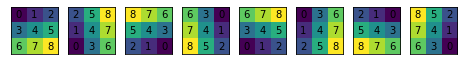

In [3]:
def plot_indices(indices):
    assert len(indices.shape) == 4
    nto, nti, k, k = indices.shape
    for m in range(nti):
        plt.figure(figsize=(nto,2))
        for l in range(nto):
            plt.subplot(1,nto, l+1)
            idxs = indices[l,m,:,:]
            plt.imshow(idxs)
            #plt.imshow(idxs, vmin=0, vmax=np.max(indices))
            plt.xticks([]); plt.yticks([])
            for j in range(idxs.shape[0]):
                for i in range(idxs.shape[1]):
                    plt.text(i,j,idxs[j,i], ha='center',va='center')
        plt.show()

plot_indices(model.layers[1].indices)

Convert the GroupConv2D model into a normal Conv2D model and get same performance during inference.

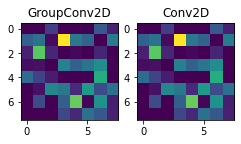

In [2]:
from layers import GroupConv2D, Conv2D

input_shape = (8,8,2)

d = np.random.randn(1, *input_shape)

x = x_in = Input(input_shape)
x = GroupConv2D(12, 3, group='D4', padding='same', activation='relu')(x)
x = GroupConv2D(12, 3, group='D4', padding='same', activation='relu')(x)
s = x.shape
x = Reshape((s[1], s[2], -1))(x)
model_1 = Model(x_in, x)

y_pred_1 = model_1(d)

x = x_in = Input(input_shape)
x = Conv2D(12*8, 3, padding='same', activation='relu')(x)
x = Conv2D(12*8, 3, padding='same', activation='relu')(x)
model_2 = Model(x_in, x)

for i in [1,2]:
    model_2.layers[i].set_weights([model_1.layers[i].transformed_kernel])

y_pred_2 = model_2(d)

plt.figure(figsize=(8,2))
plt.subplot(141); plt.title('GroupConv2D')
plt.imshow(y_pred_1[0,:,:,0])
plt.subplot(142); plt.title('Conv2D')
plt.imshow(y_pred_2[0,:,:,0])
plt.show()

### MaxPoolingWithArgmax2D and MaxUnpooling2D

(None, 32, 32, 10)
[(None, None, None, None), (None, 16, 16, 10), (None, 16, 16, 10)]
[(4, 32, 32, 10), (4, 16, 16, 10), (4, 16, 16, 10)]

[[0.4659 0.2935]
 [0.0227 0.4706]]
0.47061765 330
[[0.     0.    ]
 [0.     0.4706]]


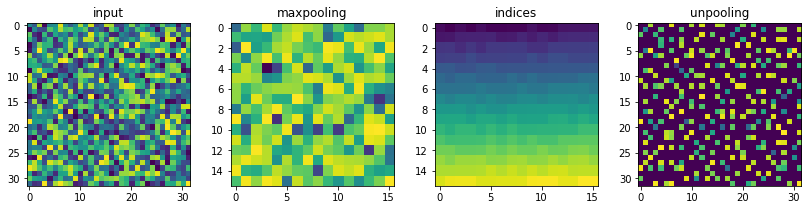

In [2]:
from layers import MaxPoolingWithArgmax2D, MaxUnpooling2D

size = 2
x = x_in = Input(shape=(32, 32, 10))
x, m = MaxPoolingWithArgmax2D(pool_size=size)(x)
x_p = x
x = MaxUnpooling2D(size=size)([x,m])
model = Model(x_in, [x,m,x_p])

print(model.input_shape)
print(model.output_shape)

batch = np.random.rand(4,32,32,10).astype('float32')

preds = model.predict(batch)
print([e.shape for e in preds])

for i in [0]:
    print()
    print(batch[0][:size,:size,i])
    print(preds[2][0][0,0,i], int(preds[1][0][0,0,i]))
    print(preds[0][0][:size,:size,i])
    
plt.figure(figsize=(14,3))
plt.subplot(141); plt.title('input')
plt.imshow(batch[0,:,:,0])
plt.subplot(142); plt.title('maxpooling')
plt.imshow(preds[2][0,:,:,0])
plt.subplot(143); plt.title('indices')
plt.imshow(preds[1][0,:,:,0])
plt.subplot(144); plt.title('unpooling')
plt.imshow(preds[0][0,:,:,0])
plt.show()

### MaxPoolingWithRelativePosition2D

(None, 24, 32, 10)
[(None, 24, 32, 10), (None, 24, 32, 20)]


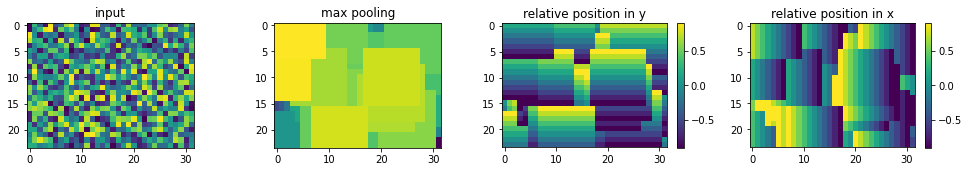

In [4]:
from layers import MaxPoolingWithRelativePosition2D

input_shape = (24, 32, 10)
x = x_in = Input(shape=input_shape)
x, p = MaxPoolingWithRelativePosition2D(pool_size=11)(x)
model = Model(x_in, [x,p])

print(model.input_shape)
print(model.output_shape)

batch = np.random.rand(4,*input_shape).astype('float32')

preds = model(batch)

plt.figure(figsize=(17,2.3))
plt.subplot(141); plt.title('input')
plt.imshow(batch[0,:,:,0])
plt.subplot(142); plt.title('max pooling')
plt.imshow(preds[0][0,:,:,0])
plt.subplot(143); plt.title('relative position in y')
plt.imshow(preds[1][0,:,:,0]); plt.colorbar()
plt.subplot(144); plt.title('relative position in x')
plt.imshow(preds[1][0,:,:,input_shape[-1]]); plt.colorbar()
plt.show()

### AddCoord2D

In [3]:
from layers import AddCoords2D

x = x_in = Input(shape=(28, 28, 3))
x = AddCoords2D()(x)
model = Model(x_in, x)

print(model.input_shape)
print(model.output_shape)

batch = np.random.rand(4,28,28,3).astype('float32')

preds = model.predict(batch)
print(preds[0][-2,:,:])

(None, 28, 28, 3)
(None, 28, 28, 5)
[[ 0.4147  0.2122  0.4213 -1.      0.9259]
 [ 0.277   0.7857  0.39   -0.9259  0.9259]
 [ 0.1146  0.0171  0.1901 -0.8519  0.9259]
 [ 0.9058  0.5574  0.0226 -0.7778  0.9259]
 [ 0.2437  0.0084  0.559  -0.7037  0.9259]
 [ 0.041   0.4743  0.4853 -0.6296  0.9259]
 [ 0.4955  0.8261  0.0195 -0.5556  0.9259]
 [ 0.0021  0.3706  0.508  -0.4815  0.9259]
 [ 0.556   0.6704  0.9399 -0.4074  0.9259]
 [ 0.331   0.3188  0.5686 -0.3333  0.9259]
 [ 0.9825  0.283   0.1884 -0.2593  0.9259]
 [ 0.5171  0.5946  0.0987 -0.1852  0.9259]
 [ 0.4246  0.4799  0.4373 -0.1111  0.9259]
 [ 0.8     0.7057  0.7673 -0.037   0.9259]
 [ 0.0434  0.3547  0.2791  0.037   0.9259]
 [ 0.5431  0.6299  0.1728  0.1111  0.9259]
 [ 0.2309  0.578   0.4045  0.1852  0.9259]
 [ 0.5644  0.0977  0.7081  0.2593  0.9259]
 [ 0.3113  0.6464  0.8978  0.3333  0.9259]
 [ 0.1136  0.4867  0.8515  0.4074  0.9259]
 [ 0.8031  0.8038  0.6576  0.4815  0.9259]
 [ 0.3704  0.3949  0.9279  0.5556  0.9259]
 [ 0.6792  0.339  

### DepthwiseConv2D

In [4]:
from layers import DepthwiseConv2D

cm = 2 # channel_multiplier

x = x_in = Input(shape=(28, 28, 3))
x = Conv2D(16, (3,3), padding='same')(x)
x = DepthwiseConv2D(cm, (3,3), padding='same')(x)
x = Conv2D(16*cm, (1,1), padding='same')(x)
model = Model(x_in, x)

print(model.input_shape)
print(model.output_shape)

batch = np.random.rand(4,28,28,3).astype('float32')

preds = model.predict(batch)
print(preds[0][0,0,:])

(None, 28, 28, 3)
(None, 28, 28, 32)
[ 0.031  -0.2327 -0.3472 -0.3636 -0.04   -0.2751 -0.1038  0.1884 -0.3158 -0.005   0.3535 -0.0798 -0.1447
  0.019  -0.5067 -0.1077  0.1027 -0.0345  0.1869  0.2644 -0.2179  0.3228  0.2713 -0.2901  0.0245  0.0948
 -0.0273 -0.0285  0.3437  0.4658 -0.0039 -0.3469]


### LayerNormalization

In [2]:
from layers import LayerNormalization

x = x_in = Input(shape=(28, 28, 3))
x = LayerNormalization()(x)
model = Model(x_in, x)

print(model.input_shape)
print(model.output_shape)

batch = np.random.rand(4,28,28,3).astype('float32')

preds = model.predict(batch)

print(np.var(batch), np.var(preds))

(None, 28, 28, 3)
(None, 28, 28, 3)
0.08324947 0.99998516


### Conv2D (Weight Normalization)

In [3]:
from layers import Conv2D, gaussian_init

x = x_in = Input(shape=(28, 28, 3))
x1 = Conv2D(10, 3, kernel_initializer=gaussian_init)(x)
x2 = Conv2D(10, 3, kernel_initializer=gaussian_init, weightnorm=True)(x)
model = Model([x_in], [x1, x2])

print(model.input_shape)
print(model.output_shape)

batch = np.random.rand(4,28,28,3).astype('float32')
preds = model.predict(batch)

print(np.var(batch), np.var(preds[0]), np.var(preds[1]))

(None, 28, 28, 3)
[(None, 26, 26, 10), (None, 26, 26, 10)]
0.084439 8.107712 0.21911137


### Resize2D

(None, 12, 12, 1)
[(None, 6, 6, 1), (None, 24, 24, 1), (None, 6, 6, 1), (None, 24, 24, 1)]


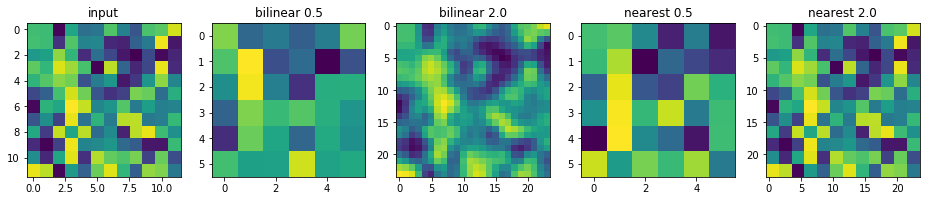

In [7]:
from layers import Resize2D

s = 12
s1, s2 = s//2, s*2

x = x_in = Input(shape=(s, s, 1))
x1 = Resize2D((s1,s1), 'bilinear')(x)
x2 = Resize2D((s2,s2), 'bilinear')(x)
x3 = Resize2D((s1,s1), 'nearest')(x)
x4 = Resize2D((s2,s2), 'nearest')(x)
model = Model(x_in, [x1,x2,x3,x4])

print(model.input_shape)
print(model.output_shape)

batch = np.random.rand(4,s,s,1).astype('float32')

preds = model.predict(batch)

plt.figure(figsize=(16,3))
plt.subplot(151); plt.title('input')
plt.imshow(batch[0,:,:,0])
plt.subplot(152); plt.title('bilinear %.1f' % (s1/s,))
plt.imshow(preds[0][0,:,:,0])
plt.subplot(153); plt.title('bilinear %.1f' % (s2/s,))
plt.imshow(preds[1][0,:,:,0])
plt.subplot(154); plt.title('nearest %.1f' % (s1/s,))
plt.imshow(preds[2][0,:,:,0])
plt.subplot(155); plt.title('nearest %.1f' % (s2/s,))
plt.imshow(preds[3][0,:,:,0])
plt.show()

### Blur2D

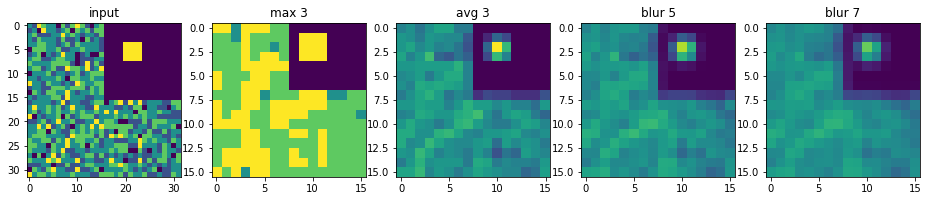

In [2]:
from layers import Blur2D

x = x_in = Input(shape=(32, 32, 10))
x1 = MaxPool2D(3, 2, padding='same')(x)
x2 = AvgPool2D(3, 2, padding='same')(x)
x3 = Blur2D(5, 2, padding='same')(x)
x4 = Blur2D(7, 2, padding='same')(x)

model = Model(x_in, [x1,x2,x3,x4])

batch = np.random.binomial(4, 0.5, size=(4,32,32,10)) / 4
batch[:,:16,16:] = 0
batch[:,4:8,20:24] = 1

preds = model.predict(batch)

plt.figure(figsize=(16,3))
plt.subplot(151); plt.title('input')
plt.imshow(batch[0,:,:,0], vmin=0, vmax=1)
plt.subplot(152); plt.title('max 3')
plt.imshow(preds[0][0,:,:,0], vmin=0, vmax=1)
plt.subplot(153); plt.title('avg 3')
plt.imshow(preds[1][0,:,:,0], vmin=0, vmax=1)
plt.subplot(154); plt.title('blur 5')
plt.imshow(preds[2][0,:,:,0], vmin=0, vmax=1)
plt.subplot(155); plt.title('blur 7')
plt.imshow(preds[3][0,:,:,0], vmin=0, vmax=1)
plt.show()